# Проект: Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки**

-    DateCrawled — дата скачивания анкеты из базы
-    VehicleType — тип автомобильного кузова
-    RegistrationYear — год регистрации автомобиля
-    Gearbox — тип коробки передач
-    Power — мощность (л. с.)
-    Model — модель автомобиля
-    Kilometer — пробег (км)
-    RegistrationMonth — месяц регистрации автомобиля
-    FuelType — тип топлива
-    Brand — марка автомобиля
-    NotRepaired — была машина в ремонте или нет
-    DateCreated — дата создания анкеты
-    NumberOfPictures — количество фотографий автомобиля
-    PostalCode — почтовый индекс владельца анкеты (пользователя)
-    LastSeen — дата последней активности пользователя

**Целевой признак**
-     Price — цена (евро)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Общий-осмотр-и-обработка-данных" data-toc-modified-id="Общий-осмотр-и-обработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Общий осмотр и обработка данных</a></span></li><li><span><a href="#Подготовка-данных-для-моделей" data-toc-modified-id="Подготовка-данных-для-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных для моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Общий осмотр и обработка данных

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor

import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
#функция для чтения файла
def file_reader(file):
    
    df = pd.read_csv(file)
    print('=======================================')
    print('Первые пять строк:')
    print('=======================================')
    display(df.head(5))
    print('=======================================')
    print('Общая информация по датасету:')
    print('=======================================')
    print(df.info())
    print('=======================================')
    print('Статистическая информация по датасету:')
    print('=======================================')
    display(df.describe())
    print('=======================================')
    print('Количество пропусков по столбцам:')
    print('=======================================')
    print(df.isna().sum())
    print('Количество дубликатов:')
    print('=======================================')
    print(df.duplicated().sum())
    
    return df

In [3]:
df = file_reader("/datasets/autos.csv")

Первые пять строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Общая информация по датасету:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  ob

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество пропусков по столбцам:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
Количество дубликатов:
4


**Промежуточные наблюдения №1:**

- Признаки DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen - не будем использовать в прогнозировании как неинформативные в плане предикции цены
- Формат признака NotRepaired заменим с no/yes на 0/1 (с object на int).
- Минимальная цена (целевой признак) = 0. 
- Минимальный год регистрации автомобиля (Registration Year) = 1000, максимальный = 9999.
- Минимальная мощность автомобиля (Power) = 0, максимальная = 20000.
- Наблюдаем пропуски в признаках VehicleType, Gearbox, Model, FuelType. Их можно заменить по среднему значению данных остальных столбцов. Большое число пропусков в признаке NotRepaired (>70 тыс наблюдений), заменим пропуски на 0 (не была в ремонте).
- В признаке Brand нет пропусков, а для моделей около 20 тыс пропусков.
- Всего выявлено 4 дубликата. Необходимо произвести проверку, из-за чего данные могли задублироваться (ошибка ввода данных, когда одно и то же наблюдение случайно было введено более одного раза, ошибка при выгрузке данных и тд)


In [4]:
#фукнкция определения пропусков и нулей
def zero_na_table(dataset):
    zeros = (dataset==0).sum()
    nas = dataset.isna().sum()
    zeros_percent = (dataset==0).sum() / len(dataset) * 100
    nas_percent = dataset.isna().sum() / len(dataset) * 100
    investigation_table = pd.concat([zeros, zeros_percent, nas, nas_percent], axis=1)
    investigation_table = investigation_table.rename(columns={0:"Zero values", 1:"Zero values %", 2:"Missing values", 3:"Missing values %"})
    display(investigation_table)
    print('Общее число наблюдений: {0}'.format(len(dataset)))


In [5]:
zero_na_table(df)

,Zero values,Zero values %,Missing values,Missing values %
DateCrawled,0,0.000000,0,0.000000
Price,10772,3.039769,0,0.000000
VehicleType,0,0.000000,37490,10.579368
RegistrationYear,0,0.000000,0,0.000000
Gearbox,0,0.000000,19833,5.596709
Power,40225,11.351162,0,0.000000
Model,0,0.000000,19705,5.560588
Kilometer,0,0.000000,0,0.000000
RegistrationMonth,37352,10.540425,0,0.000000
FuelType,0,0.000000,32895,9.282697


Общее число наблюдений: 354369


In [6]:
length_before = len(df)

In [7]:
#доля нулей по цене
len(df[df['Price'] == 0])/len(df)

0.030397692800442477

In [8]:
#доля наблюдений с регистрацией до 1970 года
len(df[df['RegistrationYear'] < 1970])/len(df)

0.0037757253032855583

In [9]:
#доля наблюдений с регистрацией после 2022 года
len(df[(df['RegistrationYear'] > 2022)])/len(df)

0.00029630131303810434

In [10]:
#доля нулей мощности
len(df[(df['Power'] == 0)])/len(df)

0.11351162206626426

In [11]:
#доля сверхмощных авто >1000 лс
len(df[(df['Power'] > 1000)])/len(df)

0.0008522190146429287

In [12]:
#общая доля вышеперечисленных условий
len(df[(df['Price'] == 0) | (df['RegistrationYear'] < 1970) | (df['RegistrationYear'] > 2022) | (df['Power'] == 0) | (df['Power'] > 1000)])/len(df)

0.13592893283554713

In [13]:
#общая доля вышеперечисленных условий без нулевой мощности
len(df[(df['Price'] == 0) | (df['RegistrationYear'] < 1970) | (df['RegistrationYear'] > 2022) | (df['Power'] > 1000)])/len(df)

0.034740623474400975

**Промежуточные наблюдения №2:**

- Доля наблюдений с нулевой ценой примерно равна 3%.
- Доля наблюдений со старыми машинами до 1970-го регистрации года примерно равна 0.4%.
- Доля наблюдений с ошибочным годом регистрации (после 2022-го года) примерно равна 0.03%.
- Доля наблюдений со сверхмощностью (>1000 лс) примерно равна 0.09%.
- **Доля наблюдений с нулевой мощностью примерно равна 11.3%.**
- Общая доля по всем "проблемным" наблюдениям примерно равна 13.6%, эта же доля без наблюдений с нулевой мощностью - примерно 3.5%.


- Необходимо заполнить нулевые мощности на медиану по имеющимся моделям автомобилей

1. Удалим дубликаты

In [14]:
df.duplicated().sum()

4

In [15]:
df = df.drop_duplicates()

In [16]:
df.duplicated().sum()

0

2. Удалим неинформативные для предикции столбцы

In [17]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

3. Заменим наблюдения с нулевой мощностью на пропуски.

In [18]:
df['Power'][(df['Power'] <= 0)] = None

In [19]:
len(df)

354365

4. Удалим безмодельные записи, заполним пропуски по моделям

Зная модель автомобиля, можно предположить информацию по типу коробки, типу автомобильного кузова, типу топлива и мощности. 

In [20]:
df = df[~df['Model'].isna()]

In [21]:
def na_median_filler(dataset, column, *filler):
    '''
    Метод заполняет пропуски столбца column медианой столбцов filler
    '''
    return (dataset[column].fillna(dataset.groupby(*filler)[column].transform('median')))

def na_mode_filler(dataset, column, *filler):
    '''
    Метод заполняет пропуски столбца column модой столбцов filler
    '''
    return (dataset[column].fillna(dataset.groupby(*filler)[column].transform(lambda x: x.value_counts().idxmax())))

In [22]:
df.isna().sum()

Price                   0
VehicleType         30662
RegistrationYear        0
Gearbox             15702
Power               33931
Model                   0
Kilometer               0
FuelType            25732
Brand                   0
NotRepaired         62100
dtype: int64

In [23]:
df['Gearbox'] = na_mode_filler(df, 'Gearbox', ['Model'])

In [24]:
df['FuelType'] = na_mode_filler(df, 'FuelType', ['Model'])

In [25]:
df['VehicleType'] = na_mode_filler(df, 'VehicleType', ['Model'])

In [26]:
df['Power'] = na_median_filler(df, 'Power', ['Model'])

Удалим наблюдения 1) с нулевой ценой 2) с машинами до 1970-го года и после 2022-го года 3) со сверхмощными автомобилями (>1000 лс). 

In [27]:
len(df)

334660

In [28]:
df = df[(df['Price'] > 0) & (df['RegistrationYear'] >= 1970) & (df['RegistrationYear'] < 2022) & (df['Power'] < 1000)]

In [29]:
len(df)

324980

In [30]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
NotRepaired         57906
dtype: int64

Большой количество пропусков по признаку отремонтированного авто 'NotRepaired'. Удалять не корректно, слишком большой объем. Будем считать, что неуказанная информация говорит об отсутствии ремонта. В будущем необходимо сделать это поле ввода обязательным для заполнения.

In [31]:
df['NotRepaired'] = df['NotRepaired'].map({'yes':1, 'no':0})
df['NotRepaired'] = df['NotRepaired'].fillna(0)
df['NotRepaired'] = df['NotRepaired'].astype('int')

In [32]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324980 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             324980 non-null  int64  
 1   VehicleType       324980 non-null  object 
 2   RegistrationYear  324980 non-null  int64  
 3   Gearbox           324980 non-null  object 
 4   Power             324980 non-null  float64
 5   Model             324980 non-null  object 
 6   Kilometer         324980 non-null  int64  
 7   FuelType          324980 non-null  object 
 8   Brand             324980 non-null  object 
 9   NotRepaired       324980 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 27.3+ MB


In [34]:
features_to_distplot = ['Price', 'Power', 'Kilometer']
features_to_barplot = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
features_to_pieplot = ['Brand', 'Model']

In [35]:
#функция построения графиков
def hist_builder(data_column, label, bins):
   
    sns.set(rc={"figure.figsize":(15, 15)}, font_scale=1)
    f, axes = plt.subplots(1, 2)
    
    
    (sns.distplot(data_column, bins=bins, ax=axes[0])
     .set(title='Плотность распределения признака: {0}'.format(label),
          xlabel='Признак {0}'.format(label),
          ylabel='Плотность признака {0}'.format(label)))

    (sns.boxplot(data_column, orient='h', ax=axes[1])
       .set(title='Boxplot для признака {0}'.format(label),
        xlabel='Признак {0}'.format(label)))
    plt.show()
#функция анализа аномалий
def anomaly_detection(data_column, label):
    anomaly_threshold_up = data_column.quantile(0.75) + (data_column.quantile(0.75) - data_column.quantile(0.25)) * 1.5
    anomaly_threshold_down = data_column.quantile(0.25) - (data_column.quantile(0.75) - data_column.quantile(0.25)) * 1.5
    anomaly_percent = round(len(data_column[(data_column > anomaly_threshold_up) | (data_column < anomaly_threshold_down)]) / len(data_column) * 100, 2)
    print("Доля выбросов параметра " + label + " равно: " + str(anomaly_percent) + "%")
    
#итоговая функция
def check_param(bins, dataset):
    print('=======================================')
    print("Анализ параметров датасета")
    print('=======================================')
    for column in dataset.columns:
        print('=======================================')
        print("Анализ параметра '" + column + "':")
        print('=======================================')
        hist_builder(dataset[column], column, bins)
        anomaly_detection(dataset[column], column)


Анализ параметров датасета
Анализ параметра 'Price':


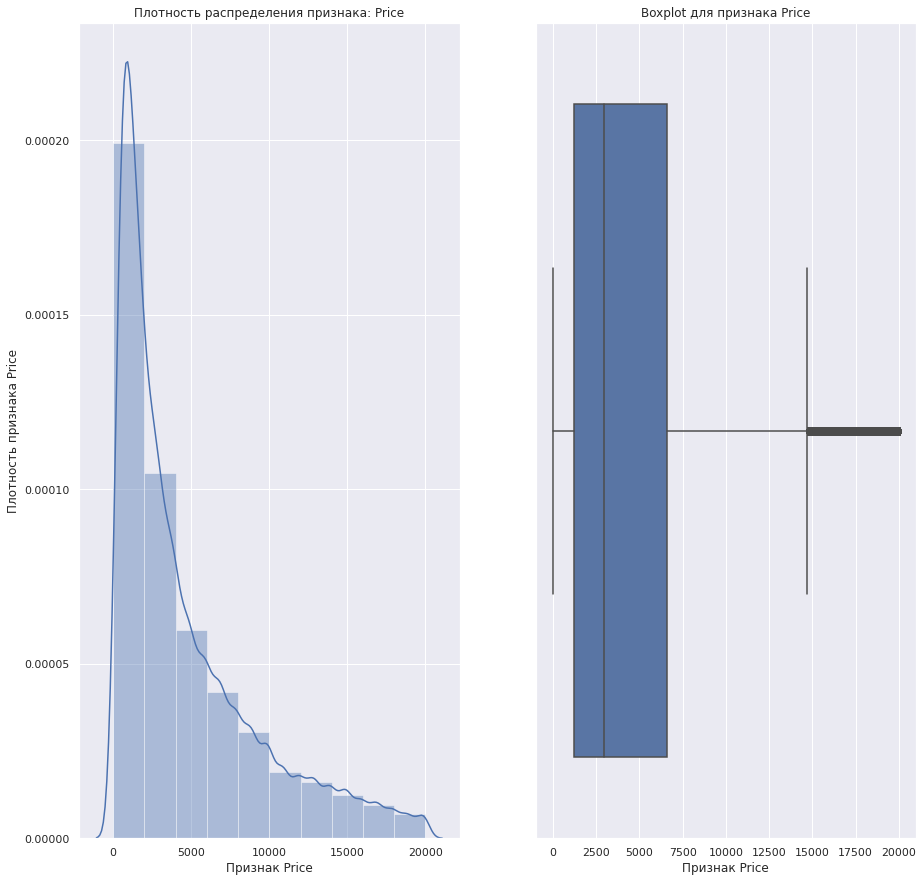

Доля выбросов параметра Price равно: 5.16%
Анализ параметра 'Power':


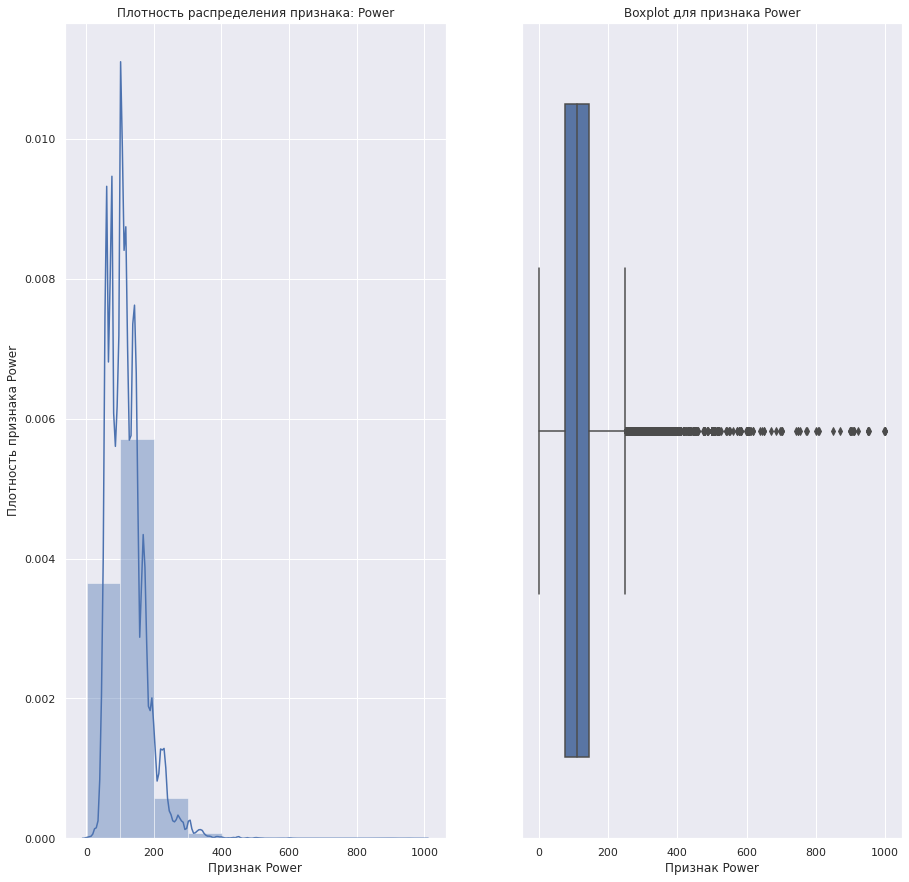

Доля выбросов параметра Power равно: 2.0%
Анализ параметра 'Kilometer':


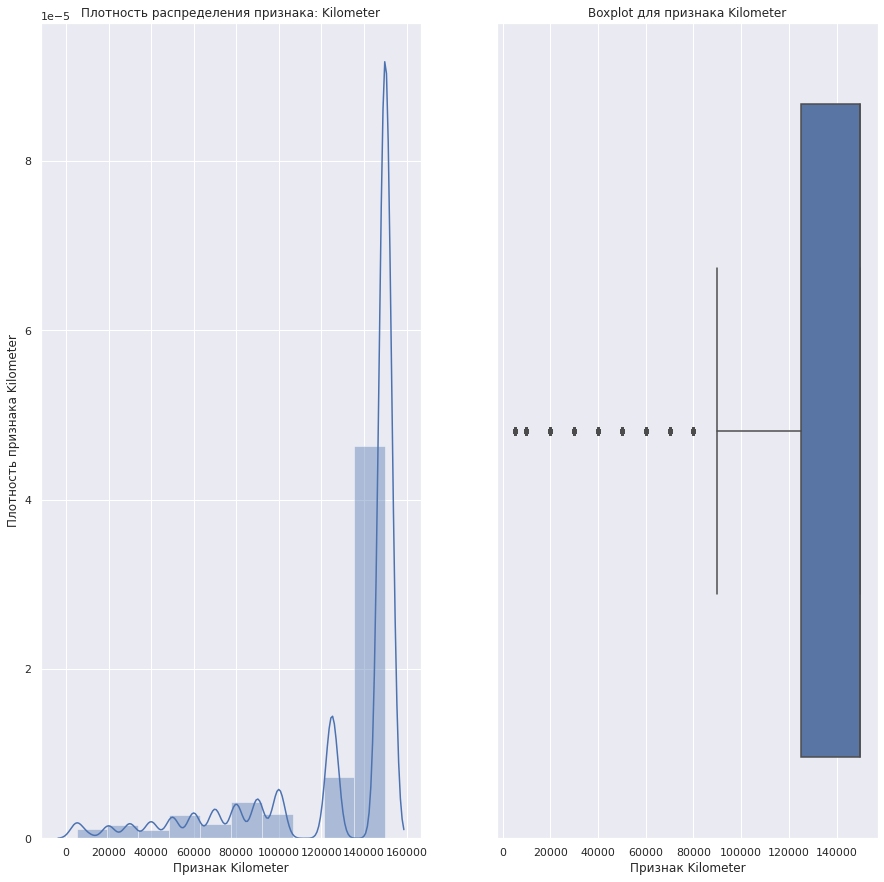

Доля выбросов параметра Kilometer равно: 14.72%


In [36]:
#вызываем функцию осмотра параметров
check_param(10, df[features_to_distplot])

**Промежуточные наблюдения №3:**

- Распределение целевого признака цены скошено вправо (медиана 2700 < среднего значения 4416). 
- Распределение признака мощности скошено вправо (медиана 105 < среднего значения 110). 
- Распределение признака километража скошено влево (медиана 150000 > среднего значения 128211). 

In [37]:
#функция построения столбчатых диаграмм
def barplot_builder(dataset):
    
    print('=======================================')
    print("Анализ параметров датасета")
    print('=======================================')
    for column in dataset.columns:
        print('=======================================')
        print("Анализ параметра '" + column + "':")
        print('=======================================')
        sns.set(rc={"figure.figsize":(10, 10)}, font_scale=1)   
        (sns.barplot(x=dataset[column].value_counts().index, y=dataset[column].value_counts())
             .set(title='Столбчатая диаграмма признака: {0}'.format(column),
              xlabel='Признак {0}'.format(column),
              ylabel='Количество наблюдений признака {0}'.format(column)))
        plt.show()

Анализ параметров датасета
Анализ параметра 'VehicleType':


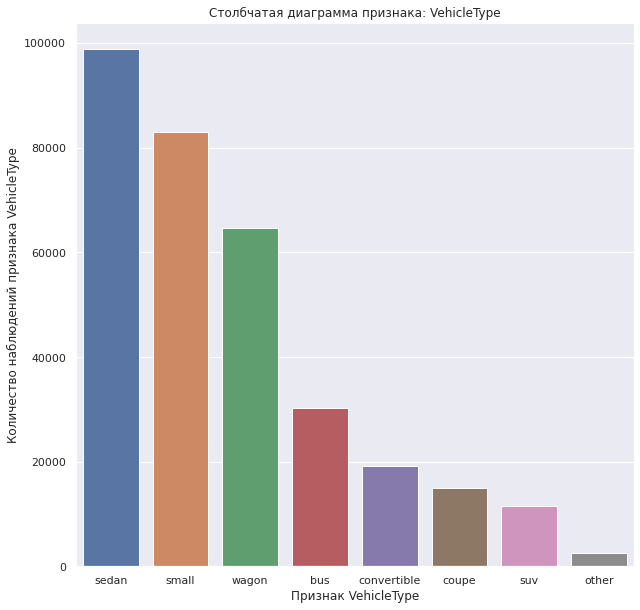

Анализ параметра 'Gearbox':


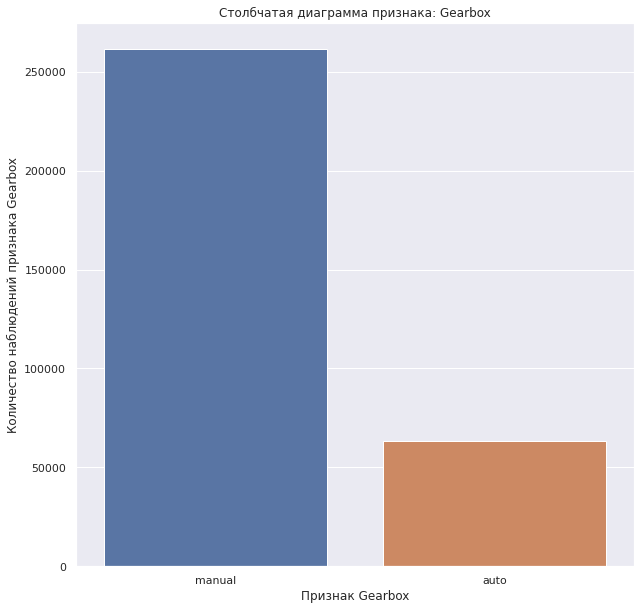

Анализ параметра 'FuelType':


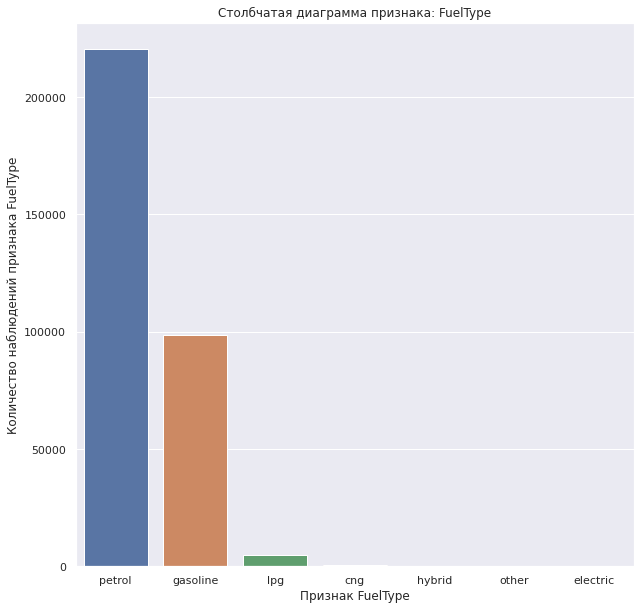

Анализ параметра 'NotRepaired':


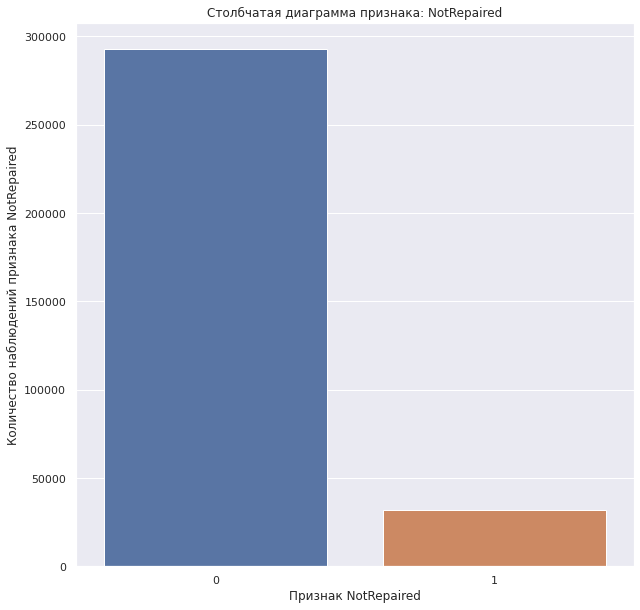

In [38]:
barplot_builder(df[features_to_barplot])

**Промежуточные наблюдения №4:**

- Топ-3 популярных объявлений по типу автомоблиьного кузова: sedan, small, wagon
- Объявления авто с механической коробкой передач почти в 5 раз больше, чем с автоматической коробкой передач.
- Наиболее популярные объявления по типу топлива: petrol и gasoline. Количество объявлений остальных групп топлива незначительно.

In [39]:
#функция построения круговых диаграмм
def pieplot_builder(dataset):
    
    print('=======================================')
    print("Анализ параметров датасета")
    print('=======================================')
    for column in dataset.columns:
        print('=======================================')
        print("Анализ параметра '" + column + "':")
        print('=======================================')
        a = pd.DataFrame(data={column: [df[column].value_counts()[5:].sum()]}, index=['Not_top_5'])
        b = pd.DataFrame(df[column].value_counts()[:5])
        c = pd.concat([b,a])

        plt.pie(c.values.flatten(), labels=c.index)
        
        plt.legend(c.index, loc='best')
        plt.show()

Анализ параметров датасета
Анализ параметра 'Brand':


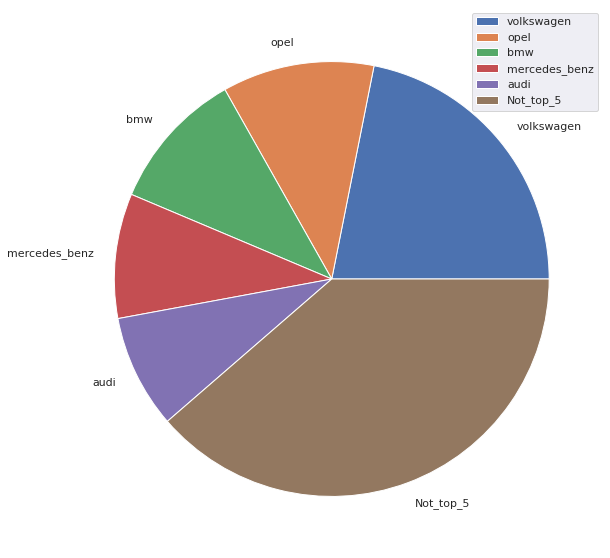

Анализ параметра 'Model':


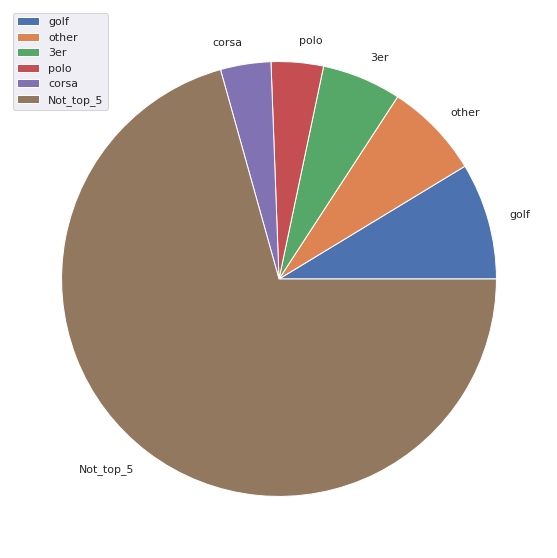

In [40]:
pieplot_builder(df[features_to_pieplot])

Топ-5 брендов автомобилей в объявлениях: volkswagen, opel, bmw, mercedes_benz, audi

In [41]:
#вызываем функцию с нулями/пропусками полученного датасета
zero_na_table(df)

,Zero values,Zero values %,Missing values,Missing values %
Price,0,0.000000,0,0.0
VehicleType,0,0.000000,0,0.0
RegistrationYear,0,0.000000,0,0.0
Gearbox,0,0.000000,0,0.0
Power,0,0.000000,0,0.0
Model,0,0.000000,0,0.0
Kilometer,0,0.000000,0,0.0
FuelType,0,0.000000,0,0.0
Brand,0,0.000000,0,0.0
NotRepaired,293145,90.204013,0,0.0


Общее число наблюдений: 324980


In [42]:
length_after = len(df)

In [43]:
print('Доля записей от исходника после удаления некорректных значений или пропущенных значений: {0:.2%}'.format(length_after/length_before))

Доля записей от исходника после удаления некорректных значений или пропущенных значений: 91.71%


In [44]:
df[features_to_barplot + features_to_pieplot].nunique()

VehicleType      8
Gearbox          2
FuelType         7
NotRepaired      2
Brand           39
Model          249
dtype: int64

Для GearBox можно было применить OneHotEncoder, для остальных категориальных признаков число разновидностей значительно, применим LabelEncoder для всех категориальных признаков

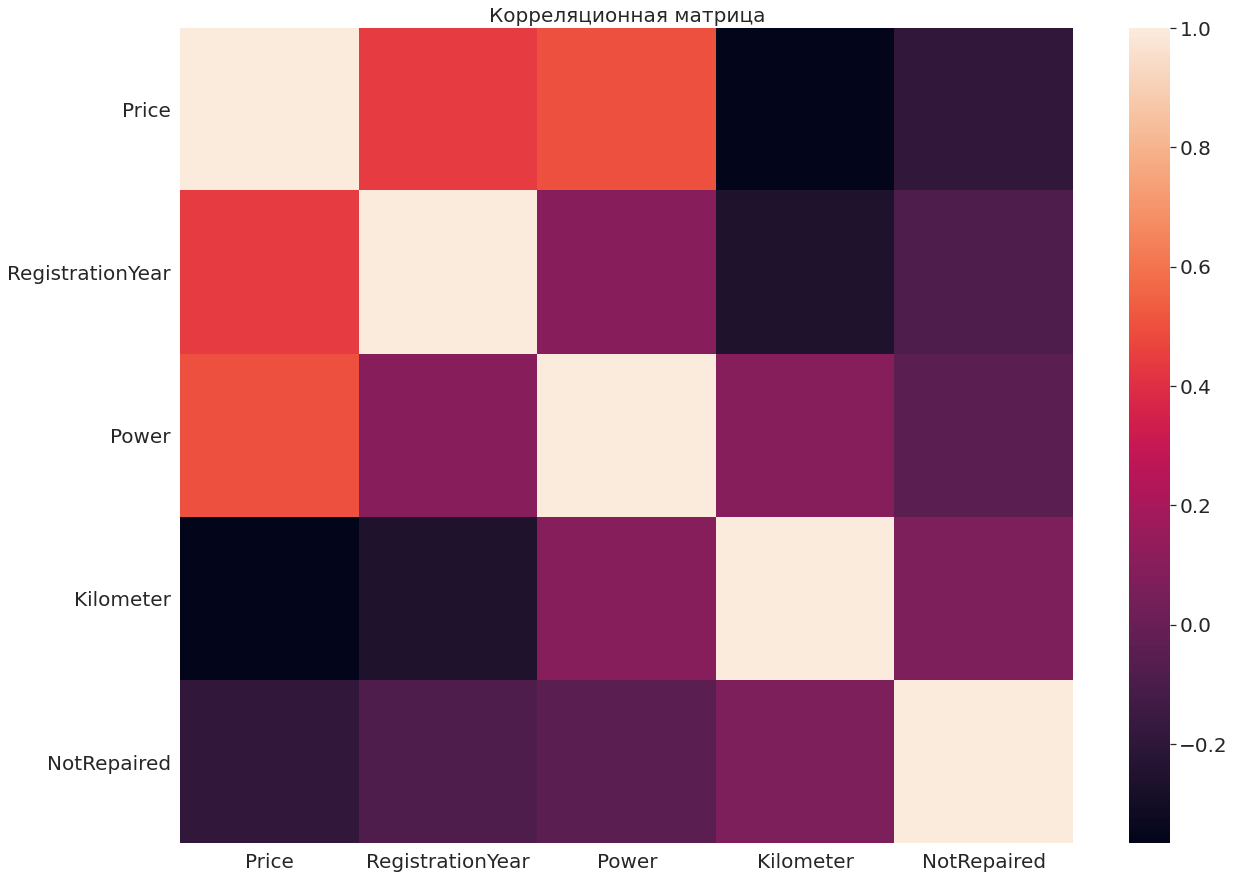

In [45]:
#функция построения heatmap'а корреляционной матрицы
def heatmap_builder(df):

    plt.figure(figsize=(20,15))
    plt.rc('xtick', labelsize=20)  
    plt.rc('ytick', labelsize=20)    
    plt.title("Корреляционная матрица", fontsize=20)
    sns.heatmap(df.corr());
    
    plt.show()
    

heatmap_builder(df) 

In [46]:
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,0
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,0
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,0
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,0
5,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,1


Заметна корреляция Мощность авто - Цена, Год регистрации авто - цена. Объяснить это можно тем, что чем новее и мощнее авто, тем больше его стоимость.

**Выводы по пункту 1:**

- Удалили признаки DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen - не будем использовать в прогнозировании как неинформативные в плане предикции цены
- Формат признака NotRepaired заменили с no/yes на 0/1 (с object на int).
- Удалили записи с ценой (целевой признак) = 0. 
- Удалили записи с годом регистрации автомобиля (Registration Year) <1970 г и > 2022 г.
- Заменили нулевые показатели по мощности на медиану по моделям, удалили сверхмощные авто > 1000 лс
- Заменили пропуски в признаках VehicleType, Gearbox, FuelType на моду по моделям. Большой количество пропусков по признаку отремонтированного авто 'NotRepaired'. Удалять не корректно, слишком большой объем. Будем считать, что неуказанная информация говорит об отсутствии ремонта. В будущем необходимо сделать это поле ввода обязательным для заполнения.
- Всего выявлено 4 дубликата. Необходимо произвести проверку, из-за чего данные могли задублироваться (ошибка ввода данных, когда одно и то же наблюдение случайно было введено более одного раза, ошибка при выгрузке данных и тд)
- **Доля записей от исходника после удаления некорректных значений или пропущенных значений: 91.71%**

**В изначальном датасете:**
- Доля наблюдений с нулевой ценой примерно равна 3%.
- Доля наблюдений со старыми машинами до 1970-го регистрации года примерно равна 0.4%.
- Доля наблюдений с ошибочным годом регистрации (после 2022-го года) примерно равна 0.03%.
- Доля наблюдений со сверхмощностью (>1000 лс) примерно равна 0.09%.
- **Доля наблюдений с нулевой мощностью примерно равна 11.3%.**
- Общая доля по всем "проблемным" наблюдениям примерно равна 13.6%, эта же доля без наблюдений с нулевой мощностью - примерно 3.5%.

**Осмотр данных:**

- Распределение целевого признака цены скошено вправо (медиана 2700 < среднего значения 4416). 
- Распределение признака мощности скошено вправо (медиана 105 < среднего значения 110). 
- Распределение признака километража скошено влево (медиана 150000 > среднего значения 128211).
- Топ-3 популярных объявлений по типу автомоблиьного кузова: sedan, small, wagon
- Объявления авто с механической коробкой передач почти в 5 раз больше, чем с автоматической коробкой передач.
- Наиболее популярные объявления по типу топлива: petrol и gasoline. Количество объявлений остальных групп топлива незначительно.
- Топ-5 брендов автомобилей в объявлениях: volkswagen, opel, bmw, mercedes_benz, audi

## Подготовка данных для моделей

План данного раздела:

1. Создаем копию полученного датасета
2. Для датасета №1 (используем для DummyRegressor, RandomForestRegressor, XGBoost):

- Делим выборку на обучающую и тестовую
- Применяем стандартизацию
- Применяем LabelEncoding

3. Для датасета №2 3 (используем для lightGBM и CatBoost, №3 для проверки влияния стандартизации):

- Делим выборку на обучающую и тестовую
- Применяем стандартизацию **(проверим факт о том, что для древовидных моделей в бустинге стандартизация необязательна. Создадим класс, в котором сможем включать и отключать необходимые операции)**
- Меняем тип категориальных признаков на category для их подачи на вход lightGBM и CatBoost

4. Для датасета №4 (только линейные модели - LinearReression, Lasso, Ridge):

- Делим выборку на обучающую и тестовую
- Применяем стандартизацию
- Применяем OneHotEncoding

In [47]:
#создаем копию датасета
df_category = df.copy(deep=True)

In [48]:
#создаем списки с результатами
fit_times_no_tune = []
predict_times_no_tune = []
rmse_results_no_tune = []

fit_times_with_tune = []
predict_times_with_tune = []
rmse_results_with_tune = []

fit_times_test = []
predict_times_test = []
rmse_results_test = []


In [49]:
class dataset_framework:
    '''
    Описание класса:
    
    Создает и предобрабатывает датасет в необходимом ключе:
    need_data_normalization - нормализация, 
    need_category_encode - перевод категориальных признаков в номинальные через labelEncoder,
    need_category_ohe_encode - перевод категориальных признаков в номинальные через ohe,
    need_category_boosting - смена формата категориальных признаков
    
    Позволяет найти оптимальные параметры модели, функция model_params_grid.
    Обучает и оценивает полученную модель (с и без учета оптимизации), результаты сохраняет в соответствующие списки:
    - времени обучения
    - время предсказания
    - RMSE
    
    '''
    def __init__(self, dataset, need_data_normalization, need_category_label_encode, need_category_boosting, need_ohe_encode):
        #constructor
        self.dataset = dataset
        self.data_division(self.dataset)

        if (need_data_normalization):
            self.data_normalization(self.dataset)
        if (need_category_label_encode):
            self.category_encode(self.dataset)
        if (need_ohe_encode):
            self.category_ohe_encode(self.dataset)
        if (need_category_boosting):
            self.category_boosting(self.dataset)
        self.dataset_overview()

    def data_division(self, dataset):
        #data divided into features and target
        self.features = dataset.drop(['Price'], axis=1)
        self.target = dataset['Price']

        self.features_train_valid, self.features_test, self.target_train_valid, self.target_test = train_test_split(self.features, self.target, test_size=0.2, random_state=12345)
        self.features_train, self.features_valid, self.target_train, self.target_valid = train_test_split(self.features_train_valid, self.target_train_valid, test_size=0.25, random_state=12345)
        
        
        print("Размер обучающей выборки: {0}, {1}".format(self.features_train.shape, self.target_train.shape))
        print("Размер валидационной выборки: {0}, {1}".format(self.features_valid.shape, self.target_valid.shape))
        print("Размер тестовой выборки: {0}, {1}".format(self.features_test.shape, self.target_test.shape))
        
    def data_normalization(self, dataset):
        #normalizing numerics
        self.scaler = StandardScaler()
        self.numerics_list = list(self.features.select_dtypes(include=['float', 'int']).columns)
        self.numerics_list.remove('NotRepaired')
        self.scaler.fit(self.features_train[self.numerics_list])
        self.features_train[self.numerics_list] = self.scaler.transform(self.features_train[self.numerics_list])
        self.features_valid[self.numerics_list] = self.scaler.transform(self.features_valid[self.numerics_list])
        self.features_train_valid[self.numerics_list] = self.scaler.transform(self.features_train_valid[self.numerics_list])
        self.features_test[self.numerics_list] = self.scaler.transform(self.features_test[self.numerics_list])

    def category_encode(self, dataset):
        #label encoder application
        self.label_encoder = LabelEncoder()
        self.categories = list(self.features.select_dtypes(include='object').columns)

        for column in self.categories:
            self.label_encoder.fit(self.features[column])
            self.features_train[column] = self.label_encoder.transform(self.features_train[column])
            self.features_valid[column] = self.label_encoder.transform(self.features_valid[column])
            self.features_train_valid[column] = self.label_encoder.transform(self.features_train_valid[column])
            self.features_test[column] = self.label_encoder.transform(self.features_test[column])
    
    def category_ohe_encode(self, dataset):
        #ohe (encoder) application

        #потенциально, можно уменьшать число признаков путем совмещения брэнда и модели авто:
        #data_to_change = [self.features, self.features_train, self.features_valid, self.features_test]
        #for data in data_to_change:
        #    data['ohe_model'] = data['Brand'].astype(str) + '_' + data['Model'].astype(str)
        #   data = data.drop(['Brand', 'Model'], axis=1)
        
        self.categories = list(self.features.select_dtypes(include='object').columns)
        
        for column in self.categories:
            dummy_df = pd.get_dummies(self.features[column], drop_first=True, prefix=column)
            self.features = self.features.drop(column, axis=1)
            self.features = self.features.join(dummy_df)
            
        self.features_train_valid, self.features_test = train_test_split(self.features, test_size=0.2, random_state=12345)
        self.features_train, self.features_valid = train_test_split(self.features_train_valid, test_size=0.25, random_state=12345)
      
        print("Размер после ohe обучающей выборки: {0}, {1}".format(self.features_train.shape, self.target_train.shape))
        print("Размер после ohe валидационной выборки: {0}, {1}".format(self.features_valid.shape, self.target_valid.shape))
        print("Размер после ohe тестовой выборки: {0}, {1}".format(self.features_test.shape, self.target_test.shape))
            
        
    def category_boosting(self, dataset):
        #categories into category format type
        self.categories = list(self.features.select_dtypes(include='object').columns)
        self.categories.append('NotRepaired')

        for category in self.categories:
            self.features_train[category] = self.features_train[category].astype('category')
            self.features_valid[category] = self.features_valid[category].astype('category')
            self.features_train_valid[category] = self.features_train_valid[category].astype('category')
            self.features_test[category] = self.features_test[category].astype('category')
            
    def dataset_overview(self):
        display(self.features_train.head(5))
        self.features_train.info()
     
    def model_checker(self, model, ordinal_fit, fill_type):
        
        if (ordinal_fit==False):

            start_fit = time.time()
            model.fit(self.features_train, self.target_train, eval_set=[(self.features_valid, self.target_valid)], verbose=100)
            end_fit = time.time()
        else:
            
            start_fit = time.time()
            model.fit(self.features_train, self.target_train)
            end_fit = time.time()
        

        if (fill_type == 'test'):
            start_predict = time.time()
            model_predictions = model.predict(self.features_test)
            end_predict = time.time()
        else:
            start_predict = time.time()
            model_predictions = model.predict(self.features_valid)
            end_predict = time.time()


        if (fill_type == 'test'):
            model_rmse = (mean_squared_error(self.target_test, model_predictions)) ** 0.5
        else:
            model_rmse = (mean_squared_error(self.target_valid, model_predictions)) ** 0.5
        
        if (fill_type == 'no_tune'):
            fit_times_no_tune.append(end_fit-start_fit)
            predict_times_no_tune.append(end_predict-start_predict)
            rmse_results_no_tune.append(model_rmse)
        elif (fill_type == 'with_tune'):
            fit_times_with_tune.append(end_fit-start_fit)
            predict_times_with_tune.append(end_predict-start_predict)
            rmse_results_with_tune.append(model_rmse)
        elif (fill_type == 'test'):
            fit_times_test.append(end_fit-start_fit)
            predict_times_test.append(end_predict-start_predict)
            rmse_results_test.append(model_rmse)
        
    def model_params_grid(self, model, model_name, **model_params):
        
        start = time.time()
        my_scorer = make_scorer(self.my_scorer_func, great_is_better = False)
        model_parameters = model_params
        kfold = KFold(n_splits=3, random_state=12345, shuffle=True)
        model_grid = GridSearchCV(model, model_parameters, cv=kfold, scoring = 'neg_mean_squared_error')
        model_grid.fit(self.features_train_valid, self.target_train_valid)
        print('''
        Лучшие параметры модели {0}: 
        
        {1}
        '''.format(model_name, model_grid.best_params_))
        
        end = time.time()
        print('''
        Количество секунд нахождения оптимальных гиперпараметров модели {0}: 
        
        {1}
        '''.format(model_name, round(end - start, 2)))
        
        return model_grid.best_params_
    
    def my_scorer_func(self, target, predictions):

        return mean_squared_error(target, predictions) ** 0.5
        

Первый датасет: Обработка категориальных признаков, с нормализацией численных признаков

In [50]:
dataset_one = dataset_framework(df, True, True, False, False)

Размер обучающей выборки: (194988, 9), (194988,)
Размер валидационной выборки: (64996, 9), (64996,)
Размер тестовой выборки: (64996, 9), (64996,)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
224040,7,-1.094004,1,-0.060433,228,0.576174,6,38,0
230487,0,0.391605,1,0.222293,198,0.576174,2,27,0
152054,4,0.243044,1,0.109202,42,0.576174,6,24,0
345155,5,-0.351200,1,-0.965155,101,0.576174,6,31,0
218876,7,1.282970,1,-0.343159,149,-2.139189,6,27,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 194988 entries, 224040 to 305120
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       194988 non-null  int64  
 1   RegistrationYear  194988 non-null  float64
 2   Gearbox           194988 non-null  int64  
 3   Power             194988 non-null  float64
 4   Model             194988 non-null  int64  
 5   Kilometer         194988 non-null  float64
 6   FuelType          194988 non-null  int64  
 7   Brand             194988 non-null  int64  
 8   NotRepaired       194988 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 14.9 MB


Второй датасет: lightGBM CatBoost с нормализацией данных

In [51]:
dataset_two = dataset_framework(df_category, True, False, True, False)

Размер обучающей выборки: (194988, 9), (194988,)
Размер валидационной выборки: (64996, 9), (64996,)
Размер тестовой выборки: (64996, 9), (64996,)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
224040,wagon,-1.094004,manual,-0.060433,v40,0.576174,petrol,volvo,0
230487,bus,0.391605,manual,0.222293,scenic,0.576174,gasoline,renault,0
152054,sedan,0.243044,manual,0.109202,astra,0.576174,petrol,opel,0
345155,small,-0.351200,manual,-0.965155,fabia,0.576174,petrol,skoda,0
218876,wagon,1.282970,manual,-0.343159,megane,-2.139189,petrol,renault,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 194988 entries, 224040 to 305120
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       194988 non-null  category
 1   RegistrationYear  194988 non-null  float64 
 2   Gearbox           194988 non-null  category
 3   Power             194988 non-null  float64 
 4   Model             194988 non-null  category
 5   Kilometer         194988 non-null  float64 
 6   FuelType          194988 non-null  category
 7   Brand             194988 non-null  category
 8   NotRepaired       194988 non-null  category
dtypes: category(6), float64(3)
memory usage: 7.3 MB


Третий датасет: lightGBM CatBoost без нормализации данных

In [52]:
dataset_three = dataset_framework(df_category, False, False, True, False)

Размер обучающей выборки: (194988, 9), (194988,)
Размер валидационной выборки: (64996, 9), (64996,)
Размер тестовой выборки: (64996, 9), (64996,)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
224040,wagon,1996,manual,116.0,v40,150000,petrol,volvo,0
230487,bus,2006,manual,131.0,scenic,150000,gasoline,renault,0
152054,sedan,2005,manual,125.0,astra,150000,petrol,opel,0
345155,small,2001,manual,68.0,fabia,150000,petrol,skoda,0
218876,wagon,2012,manual,101.0,megane,50000,petrol,renault,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 194988 entries, 224040 to 305120
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       194988 non-null  category
 1   RegistrationYear  194988 non-null  int64   
 2   Gearbox           194988 non-null  category
 3   Power             194988 non-null  float64 
 4   Model             194988 non-null  category
 5   Kilometer         194988 non-null  int64   
 6   FuelType          194988 non-null  category
 7   Brand             194988 non-null  category
 8   NotRepaired       194988 non-null  category
dtypes: category(6), float64(1), int64(2)
memory usage: 7.3 MB


In [53]:
dataset_four = dataset_framework(df, True, False, False, True)

Размер обучающей выборки: (194988, 9), (194988,)
Размер валидационной выборки: (64996, 9), (64996,)
Размер тестовой выборки: (64996, 9), (64996,)
Размер после ohe обучающей выборки: (194988, 304), (194988,)
Размер после ohe валидационной выборки: (64996, 304), (64996,)
Размер после ohe тестовой выборки: (64996, 304), (64996,)


,RegistrationYear,Power,Kilometer,NotRepaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
224040,1996,116.0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
230487,2006,131.0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152054,2005,125.0,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
345155,2001,68.0,150000,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
218876,2012,101.0,50000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 194988 entries, 224040 to 305120
Columns: 304 entries, RegistrationYear to Brand_volvo
dtypes: float64(1), int64(3), uint8(300)
memory usage: 63.2 MB


**Вывод по пункту 2:**

Создали 3 датасета (3 образца класса dataset_framework):

- Первый датасет: Для DummyRegressor, LinearRegression (+l1, l2 регуляризация), RandomForestRegressor, XGBoost. Обработка категориальных признаков, с нормализацией численных признаков: **6 моделей**
- Второй датасет: Для lightGBM CatBoost. С нормализацией численных признаков **2 модели**
- Третий датасет: Для lightGBM CatBoost. Без нормализации численных признаков **2 модели**

## Обучение моделей

In [54]:
#models_1
dr = DummyRegressor(strategy="mean")
lr = LinearRegression()
r = Ridge(random_state=12345)
l = Lasso(random_state=12345)
rfr = RandomForestRegressor(random_state=12345)
xgb = XGBRegressor(random_state=12345)
lgbm = LGBMRegressor(categorical_feature=dataset_two.categories, random_state=12345)
cb = CatBoostRegressor(cat_features = dataset_two.categories, silent=True, random_state=12345)

models_dataset_four = [lr, r, l]
models_dataset_one = [rfr, xgb]
models_dataset_two_three = [lgbm, cb]

In [55]:
%%time
#обучаем дефолтные модели
dataset_one.model_checker(dr, True, 'no_tune')
for model in models_dataset_four:
    dataset_four.model_checker(model, True, 'no_tune')
for model in models_dataset_one:
    dataset_one.model_checker(model, True, 'no_tune')    

for model in models_dataset_two_three:
    dataset_two.model_checker(model, True, 'no_tune')
for model in models_dataset_two_three:
    dataset_three.model_checker(model, True, 'no_tune')

CPU times: user 7min 35s, sys: 48.2 s, total: 8min 23s
Wall time: 8min 32s


In [56]:
pd.set_option("display.float_format", "{:.5f}".format)

In [57]:
final_table_no_tune = pd.DataFrame(data=[fit_times_no_tune, predict_times_no_tune, rmse_results_no_tune], columns=['DummyRegressor', 'LinearRegression', 'Ridge', 'Lasso', 'RandomForestRegressor', 'XGBRegressor', 'LightGBM_norm', 'CatBoost_norm', 'LightGBM_no_norm', 'CatBoost_no_norm'], index=['Learning time', 'Prediction time', 'RMSE']).T
final_table_no_tune

,Learning time,Prediction time,RMSE
DummyRegressor,0.00073,0.00024,4525.94513
LinearRegression,17.62524,0.19381,2720.38944
Ridge,2.90532,0.29402,2720.39280
Lasso,128.59796,0.23989,2751.47708
RandomForestRegressor,39.38263,2.31525,1650.98171
XGBRegressor,35.49282,0.17406,1668.03994
LightGBM_norm,4.39711,0.61103,1668.69369
CatBoost_norm,135.96143,0.36434,1654.71875
LightGBM_no_norm,4.76014,0.60659,1671.48581
CatBoost_no_norm,138.45542,0.35588,1654.71875


Из таблице выше:

- RMSE моделей lightGBM и CatBoost для датасетов 2 и 3 (с нормализацией и без) почти не отличается, но без нормализации увеличивается время обучения
- Дефолтные модели RandomForestRegressor, lightGBM, XGBRegressor и CatBoost показали лучшие результаты по rmse (RMSE<1700). Худшая модель DummyRegressor (RMSE примерно = 4500) - константная модель
- Дефолтные модели RandomForest, XGBoost, CatBoost занимают бОльшее время на обучение, чем lgbm.
- Время на предсказание всех моделей < 0.5 сек, за исключением lgbm - около 0.6 секунд и RandomForestRegressor - больше 2-х секунд.
- **В плане лучшей комбинации времени обучения и предсказания и точности предсказания следует выделить LightGBM модель. Однако в плане точности модели XGB и CatBoost также дают хороший результат, но требуют больше времени на обучение.**

**Найдем подходящие гиперпараметры моделей, возьмем лучшие по точности/времени, проверим выбранные модели на тестовой выборке.**

**1. DummyRegressor**

In [58]:
%%time
dataset_one.model_checker(dr, True, 'with_tune')

CPU times: user 1.59 ms, sys: 0 ns, total: 1.59 ms
Wall time: 1.36 ms


**2. Linear Regression**

In [59]:
%%time
dataset_four.model_checker(lr, True, 'with_tune')


CPU times: user 15.3 s, sys: 2.13 s, total: 17.4 s
Wall time: 17.4 s


**3. Lasso l1 регуляризация**

In [60]:
%%time
l = Lasso(random_state=12345)
l_parameters = { 'alpha': np.arange (0, 3, 1),
               'random_state': [12345]}
l_best_grid = dataset_one.model_params_grid(l, 'Lasso', **l_parameters)
dataset_four.model_checker(Lasso(**l_best_grid), True, 'with_tune')



        Лучшие параметры модели Lasso: 
        
        {'alpha': 0, 'random_state': 12345}
        

        Количество секунд нахождения оптимальных гиперпараметров модели Lasso: 
        
        69.1
        
CPU times: user 4min 29s, sys: 2min 26s, total: 6min 55s
Wall time: 6min 56s


**4. Ridge l2 регуляризация**

In [61]:
%%time
r = Ridge(random_state=12345)
r_parameters = { 'alpha': np.arange (0, 3, 0.25),
               'random_state': [12345]}
r_best_grid = dataset_one.model_params_grid(r, 'Ridge', **r_parameters)
dataset_four.model_checker(Ridge(**r_best_grid), True, 'with_tune')



        Лучшие параметры модели Ridge: 
        
        {'alpha': 2.75, 'random_state': 12345}
        

        Количество секунд нахождения оптимальных гиперпараметров модели Ridge: 
        
        7.21
        
CPU times: user 6.14 s, sys: 5.17 s, total: 11.3 s
Wall time: 11.3 s


**5. RandomForestRegressor**

In [62]:
%%time

rfr = RandomForestRegressor(random_state=12345)
rfr_parameters = { 'n_estimators': range (20, 200, 100),
              'max_depth': range (3,10, 5),
              #'min_samples_leaf': arange (1,5),
              #'min_samples_split': arange (2,5),
               'random_state': [12345] }
rfr_best_grid = dataset_one.model_params_grid(rfr, 'RandomForestRegressor', **rfr_parameters)
dataset_one.model_checker(RandomForestRegressor(**rfr_best_grid), True, 'with_tune')


        Лучшие параметры модели RandomForestRegressor: 
        
        {'max_depth': 8, 'n_estimators': 120, 'random_state': 12345}
        

        Количество секунд нахождения оптимальных гиперпараметров модели RandomForestRegressor: 
        
        130.17
        
CPU times: user 2min 31s, sys: 0 ns, total: 2min 31s
Wall time: 2min 33s


**6. XGBRegressor**

In [63]:
%%time

xgb = XGBRegressor(random_state=12345)
xgb_parameters = { 'n_estimators': range (10, 100,50),
              'max_depth': range (3,10, 5),
              #'reg_lambda': np.arange (0, 2, 1),
               'random_state': [12345] }
xgb_best_grid = dataset_one.model_params_grid(xgb, 'XGBRegressor',  **xgb_parameters)
dataset_one.model_checker(XGBRegressor(**xgb_best_grid), False, 'with_tune')




        Лучшие параметры модели XGBRegressor: 
        
        {'max_depth': 8, 'n_estimators': 60, 'random_state': 12345}
        

        Количество секунд нахождения оптимальных гиперпараметров модели XGBRegressor: 
        
        222.15
        
[0]	validation_0-rmse:4775.33740
[59]	validation_0-rmse:1634.44665
CPU times: user 4min 12s, sys: 0 ns, total: 4min 12s
Wall time: 4min 15s


**7. LGBMRegressor**

In [64]:
%%time

lgbm = LGBMRegressor(random_state=12345, categorical_feature=dataset_two.categories)
lgbm_parameters = { 'n_estimators': range (50, 500,400),
              'max_depth': range (3,10, 5),
              #'reg_lambda': np.arange (0, 2, 1),
               'random_state': [12345] }
lgbm_best_grid = dataset_two.model_params_grid(lgbm, 'LGBMRegressor',  **lgbm_parameters)
dataset_two.model_checker(LGBMRegressor(categorical_feature=dataset_two.categories, **lgbm_best_grid), False, 'with_tune')


        Лучшие параметры модели LGBMRegressor: 
        
        {'max_depth': 8, 'n_estimators': 450, 'random_state': 12345}
        

        Количество секунд нахождения оптимальных гиперпараметров модели LGBMRegressor: 
        
        132.8
        
[100]	valid_0's l2: 2.79637e+06
[200]	valid_0's l2: 2.68152e+06
[300]	valid_0's l2: 2.62646e+06
[400]	valid_0's l2: 2.59033e+06
CPU times: user 2min 31s, sys: 0 ns, total: 2min 31s
Wall time: 2min 33s


**8. CatBoostRegressor**

In [65]:
%%time

cb = CatBoostRegressor(random_state=12345, cat_features=dataset_two.categories, loss_function='RMSE', silent=True)
cb_parameters = {  'n_estimators': range (50, 500,400),
              'max_depth': range (3,10, 5),
              #'l2_leaf_reg': np.arange (0, 2, 1),
               'random_state': [12345] }
cb_best_grid = dataset_two.model_params_grid(cb, 'CatBoostRegressor',  **cb_parameters)
dataset_two.model_checker(CatBoostRegressor(silent=True, cat_features=dataset_two.categories, **cb_best_grid), False, 'with_tune')




        Лучшие параметры модели CatBoostRegressor: 
        
        {'max_depth': 8, 'n_estimators': 450, 'random_state': 12345}
        

        Количество секунд нахождения оптимальных гиперпараметров модели CatBoostRegressor: 
        
        450.26
        
Learning rate set to 0.189656
0:	learn: 3949.6322663	test: 3946.4690271	best: 3946.4690271 (0)	total: 340ms	remaining: 2m 32s
100:	learn: 1664.4521975	test: 1703.9854115	best: 1703.9854115 (100)	total: 20.4s	remaining: 1m 10s
200:	learn: 1592.6763436	test: 1658.0700010	best: 1658.0700010 (200)	total: 40.1s	remaining: 49.6s
300:	learn: 1548.5375389	test: 1635.1323018	best: 1635.1323018 (300)	total: 59.6s	remaining: 29.5s
400:	learn: 1514.2264718	test: 1621.6140161	best: 1621.6010912 (399)	total: 1m 20s	remaining: 9.83s
449:	learn: 1501.1655750	test: 1617.3105262	best: 1617.2745948 (444)	total: 1m 30s	remaining: 0us

bestTest = 1617.274595
bestIteration = 444

Shrink model to first 445 iterations.
CPU times: user 8min 34s, sys

In [66]:
final_table_with_tune = pd.DataFrame(data=[fit_times_with_tune, predict_times_with_tune, rmse_results_with_tune], columns=['DummyRegressor', 'LinearRegression', 'Ridge', 'Lasso', 'RandomForestRegressor', 'XGBRegressor', 'LightGBM', 'CatBoost'], index=['Learning time', 'Prediction time', 'RMSE']).T
final_table_with_tune

,Learning time,Prediction time,RMSE
DummyRegressor,0.00056,0.00024,4525.94513
LinearRegression,17.15294,0.29377,2720.38944
Ridge,346.70859,0.29130,2720.39317
Lasso,3.79591,0.29712,2720.57761
RandomForestRegressor,23.11515,0.47041,2063.65766
XGBRegressor,33.05635,0.13311,1634.44784
LightGBM,18.10412,2.79915,1605.21504
CatBoost,93.42944,0.28944,1617.27459


Таблица выше показывает результаты rmse на валидационной выборке. Отберем пять моделей для проверки на тестовой выборке: (1) Линейная регрессия (2) RandomForest (3) XGBRegressor (4) Ligbm (5) CatBoost. 

Вывод по пункту 3:

- RMSE моделей lightGBM и CatBoost для датасетов 2 и 3 (с нормализацией и без) почти не отличается, но без нормализации увеличивается время обучения
- Дефолтные модели RandomForestRegressor, lightGBM, XGBRegressor и CatBoost показали лучшие результаты по rmse (RMSE<1700). Худшая модель DummyRegressor (RMSE примерно = 4500) - константная модель
- Дефолтные модели RandomForest, XGBoost, CatBoost занимают бОльшее время на обучение, чем lgbm.
- Время на предсказание всех моделей < 0.5 сек, за исключением lgbm - около 0.6 секунд и RandomForestRegressor - больше 2-х секунд.
- **В плане лучшей комбинации времени обучения и предсказания и точности предсказания следует выделить LightGBM модель. Однако в плане точности модели XGB и CatBoost также дают хороший результат, но требуют больше времени на обучение (то же относится и RandomForestRegressor).**
- Необходимо оценить качество полученных моделей на тестовой выборке

## Анализ моделей

На тестовой выборке сравним 5 моделей:
(1) Линейная регрессия
(2) RandomForest
(3) XGBRegressor
(4) Ligbm
(5) CatBoost

In [68]:
#test models
lr_test = LinearRegression()
rfr_test = RandomForestRegressor(**rfr_best_grid)
xgb_test = XGBRegressor(**xgb_best_grid)
lgbm_test = LGBMRegressor(categorical_feature=dataset_two.categories, **lgbm_best_grid)
cb_test = CatBoostRegressor(cat_features=dataset_two.categories, **cb_best_grid)

In [69]:
%%time

dataset_four.model_checker(lr_test, True, 'test')

CPU times: user 18.8 s, sys: 0 ns, total: 18.8 s
Wall time: 18.9 s


In [70]:
%%time

dataset_one.model_checker(rfr_test, True, 'test')

CPU times: user 22 s, sys: 0 ns, total: 22 s
Wall time: 22.4 s


In [71]:
%%time

dataset_one.model_checker(xgb_test, True, 'test')

CPU times: user 30.8 s, sys: 0 ns, total: 30.8 s
Wall time: 31.1 s


In [72]:
%%time

dataset_two.model_checker(lgbm_test, True, 'test')

CPU times: user 22.2 s, sys: 0 ns, total: 22.2 s
Wall time: 22.4 s


In [73]:
%%time

dataset_two.model_checker(cb_test, True, 'test')

Learning rate set to 0.180276
0:	learn: 3977.2308568	total: 263ms	remaining: 1m 58s
1:	learn: 3552.7189165	total: 522ms	remaining: 1m 56s
2:	learn: 3195.4361847	total: 757ms	remaining: 1m 52s
3:	learn: 2921.5373965	total: 989ms	remaining: 1m 50s
4:	learn: 2715.5571456	total: 1.22s	remaining: 1m 48s
5:	learn: 2548.2696632	total: 1.43s	remaining: 1m 45s
6:	learn: 2422.7827724	total: 1.66s	remaining: 1m 44s
7:	learn: 2314.6919790	total: 1.88s	remaining: 1m 43s
8:	learn: 2235.5893010	total: 2.08s	remaining: 1m 42s
9:	learn: 2169.1782495	total: 2.29s	remaining: 1m 40s
10:	learn: 2113.1725592	total: 2.51s	remaining: 1m 40s
11:	learn: 2067.2376719	total: 2.7s	remaining: 1m 38s
12:	learn: 2032.2213018	total: 2.9s	remaining: 1m 37s
13:	learn: 2006.3381252	total: 3.08s	remaining: 1m 35s
14:	learn: 1981.8419443	total: 3.25s	remaining: 1m 34s
15:	learn: 1961.3849499	total: 3.4s	remaining: 1m 32s
16:	learn: 1944.5532974	total: 3.55s	remaining: 1m 30s
17:	learn: 1930.2778179	total: 3.7s	remaining: 1

151:	learn: 1626.2556490	total: 28.6s	remaining: 56s
152:	learn: 1625.7719016	total: 28.7s	remaining: 55.8s
153:	learn: 1625.1357179	total: 28.9s	remaining: 55.6s
154:	learn: 1624.6339529	total: 29.1s	remaining: 55.4s
155:	learn: 1624.0058398	total: 29.3s	remaining: 55.2s
156:	learn: 1623.1463378	total: 29.5s	remaining: 55.1s
157:	learn: 1622.7671371	total: 29.7s	remaining: 54.9s
158:	learn: 1621.5315437	total: 29.9s	remaining: 54.7s
159:	learn: 1620.0386370	total: 30.1s	remaining: 54.5s
160:	learn: 1619.4415069	total: 30.2s	remaining: 54.3s
161:	learn: 1618.6685565	total: 30.4s	remaining: 54.1s
162:	learn: 1617.9418655	total: 30.6s	remaining: 53.9s
163:	learn: 1616.4635104	total: 30.8s	remaining: 53.7s
164:	learn: 1615.6215343	total: 30.9s	remaining: 53.5s
165:	learn: 1615.0664371	total: 31.1s	remaining: 53.2s
166:	learn: 1614.7178927	total: 31.2s	remaining: 52.9s
167:	learn: 1614.1620183	total: 31.4s	remaining: 52.7s
168:	learn: 1613.0945000	total: 31.6s	remaining: 52.6s
169:	learn: 

302:	learn: 1550.4349136	total: 55.6s	remaining: 27s
303:	learn: 1550.2432345	total: 55.7s	remaining: 26.8s
304:	learn: 1549.8993343	total: 55.9s	remaining: 26.6s
305:	learn: 1549.4052783	total: 56.1s	remaining: 26.4s
306:	learn: 1548.8016566	total: 56.3s	remaining: 26.2s
307:	learn: 1548.2283004	total: 56.5s	remaining: 26s
308:	learn: 1547.6743772	total: 56.6s	remaining: 25.8s
309:	learn: 1547.4671297	total: 56.8s	remaining: 25.6s
310:	learn: 1547.2320361	total: 57s	remaining: 25.5s
311:	learn: 1546.9085169	total: 57.2s	remaining: 25.3s
312:	learn: 1546.5158447	total: 57.4s	remaining: 25.1s
313:	learn: 1546.1137665	total: 57.6s	remaining: 24.9s
314:	learn: 1545.9129738	total: 57.8s	remaining: 24.8s
315:	learn: 1545.7337502	total: 58s	remaining: 24.6s
316:	learn: 1545.3879055	total: 58.1s	remaining: 24.4s
317:	learn: 1544.9344356	total: 58.3s	remaining: 24.2s
318:	learn: 1544.7817672	total: 58.5s	remaining: 24s
319:	learn: 1544.3072134	total: 58.7s	remaining: 23.8s
320:	learn: 1543.537

In [74]:
test_table = pd.DataFrame(data=[fit_times_test, predict_times_test, rmse_results_test], columns=['LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'LightGBM', 'CatBoost'], index=['Learning time', 'Prediction time', 'RMSE']).T
test_table

,Learning time,Prediction time,RMSE
LinearRegression,18.76965,0.12301,2695.07513
RandomForestRegressor,21.90716,0.47554,2034.87807
XGBRegressor,30.90742,0.11534,1613.34627
LightGBM,19.62443,2.79661,1586.36475
CatBoost,85.32711,0.28990,1600.48762


Вывод по пункту 4:

- Проверили работу полученных моделей на тестовых выборках.
- Для линейной регрессии применили ohe кодирования категориальных признаков, для lgbm и catboost перевели формат категориальных признаков в 'category', для остальных - применили label encoder.
- Модель линейной регрессии показала худший результат (не учитывая константную модель), но время обучения и предсказания также минимальны. Это говорит о том, что модель не смогла расследить закономерность в данных так, как это сделали другие модели.
- Результаты по времени обучения и RMSE лучшие у LightGBM, однако время предсказания (почти 3 сек) также больше, чем у остальных моделей.


- **Итого, в плане лучшей комбинации времени обучения и предсказания и точности предсказания следует выделить LightGBM модель. Однако в плане точности модели XGB и CatBoost также дают хороший результат, но требуют больше времени на обучение (то же можно сказать и о RandomForestRegressor, судя по дефолтной модели)**

## Общий вывод


Произвели общий осмотр и обработку данных:

- Удалили признаки DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen - не будем использовать в прогнозировании как неинформативные в плане предикции цены
- Формат признака NotRepaired заменили с no/yes на 0/1 (с object на int).
- Удалили записи с ценой (целевой признак) = 0. 
- Удалили записи с годом регистрации автомобиля (Registration Year) <1970 г и > 2022 г.
- Заменили нулевые показатели по мощности на медиану по моделям, удалили сверхмощные авто > 1000 лс
- Заменили пропуски в признаках VehicleType, Gearbox, FuelType на моду по моделям. Большой количество пропусков по признаку отремонтированного авто 'NotRepaired'. Удалять не корректно, слишком большой объем. Будем считать, что неуказанная информация говорит об отсутствии ремонта. В будущем необходимо сделать это поле ввода обязательным для заполнения.
- Всего выявлено 4 дубликата. Необходимо произвести проверку, из-за чего данные могли задублироваться (ошибка ввода данных, когда одно и то же наблюдение случайно было введено более одного раза, ошибка при выгрузке данных и тд)
- Доля записей от исходника после удаления некорректных значений или пропущенных значений: 91.71%

Создали 3 датасета (3 образца класса dataset_framework):

- Первый датасет: Для DummyRegressor, LinearRegression (+l1, l2 регуляризация), RandomForestRegressor, XGBoost. Обработка категориальных признаков, с нормализацией численных признаков:
- Второй датасет: Для lightGBM CatBoost. С нормализацией численных признаков
- Третий датасет: Для lightGBM CatBoost. Без нормализации численных признаков

Анализ дефолтных моделей:

- RMSE моделей lightGBM и CatBoost для датасетов 2 и 3 (с нормализацией и без) почти не отличается, но без нормализации увеличивается время обучения
- Дефолтные модели RandomForestRegressor, lightGBM, XGBRegressor и CatBoost показали лучшие результаты по rmse (RMSE<1700). Худшая модель DummyRegressor (RMSE примерно = 4500) - константная модель
- Дефолтные модели RandomForest, XGBoost, CatBoost занимают бОльшее время на обучение, чем lgbm.
- Время на предсказание всех моделей < 0.5 сек, за исключением lgbm - около 0.6 секунд и RandomForestRegressor - больше 2-х секунд.


- **В плане лучшей комбинации времени обучения и предсказания и точности предсказания следует выделить LightGBM модель. Однако в плане точности модели XGB и CatBoost также дают хороший результат, но требуют больше времени на обучение.**

Анализ моделей с оптимальными гиперпараметрами (после тюнинга):

- Проверили работу полученных моделей на тестовых выборках.
- Для линейной регрессии применили ohe кодирования категориальных признаков, для lgbm и catboost перевели формат категориальных признаков в 'category', для остальных - применили label encoder.
- Модель линейной регрессии показала худший результат (не учитывая константную модель), но время обучения и предсказания также минимальны. Это говорит о том, что модель не смогла расследить закономерность в данных так, как это сделали другие модели.
- Результаты по времени обучения и RMSE лучшие у LightGBM, однако время предсказания (почти 3 сек) также больше, чем у остальных моделей.


- **Итого, в плане лучшей комбинации времени обучения и предсказания и точности предсказания следует выделить LightGBM модель. Однако в плане точности модели XGB и CatBoost также дают хороший результат, но требуют больше времени на обучение (то же можно сказать и о RandomForestRegressor, судя по дефолтной модели)**